<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/intelligent-data-analysis/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



def fit_eval(pipe, param_grid, name):
    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring=SCORING, n_jobs=-1, verbose=0)
    gs.fit(X_train_raw, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test_raw)

    print(f"\n================ {name} ================")
    print("Best params:", gs.best_params_)
    print(f"CV {SCORING}: {gs.best_score_:.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test f1_macro: {f1_score(y_test, y_pred, average='macro'):.4f}\n")
    print("classification_report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best.classes_)
    fig, ax = plt.subplots(figsize=(7,6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    ax.set_title(f"Confusion matrix — {name} (normalized)")
    plt.tight_layout(); plt.show()

    return {"name": name, "model": best,
            "cv_score": gs.best_score_,
            "test_f1_macro": f1_score(y_test, y_pred, average="macro")}


# Крок 1. Завантажити дані, вивести назви колонок і розмір датасета

In [60]:
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-cybersecurity-threats-2015-2024' dataset.
Path to dataset files: /kaggle/input/global-cybersecurity-threats-2015-2024


In [61]:
df = pd.read_csv(os.path.join(path, "Global_Cybersecurity_Threats_2015-2024.csv"))

print("Назви колонок:")
for col in df.columns:
    print(col)

print("\n")

print("Size rows/columns:", df.shape)

Назви колонок:
Country
Year
Attack Type
Target Industry
Financial Loss (in Million $)
Number of Affected Users
Attack Source
Security Vulnerability Type
Defense Mechanism Used
Incident Resolution Time (in Hours)


Size rows/columns: (3000, 10)


# Крок 2. Опрацювати пропуски (по можливості заповнити їх або видалити)

In [62]:
print(df.isnull().sum())

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64


Пропусків немає.

# Target - Resolution Time



## Крок 3. Візуалізувати дані (Target - Resolution Time)



In [63]:
TGT = "Incident Resolution Time (in Hours)"
DROP_COLS = ["Year"]

# Equal-frequency bins (3 classes): short / medium / long
y = pd.qcut(
    df[TGT],
    q=3,
    labels=["short","medium","long"],
)

# Drop the raw target to avoid leakage
X = df.drop(columns=DROP_COLS + [TGT])


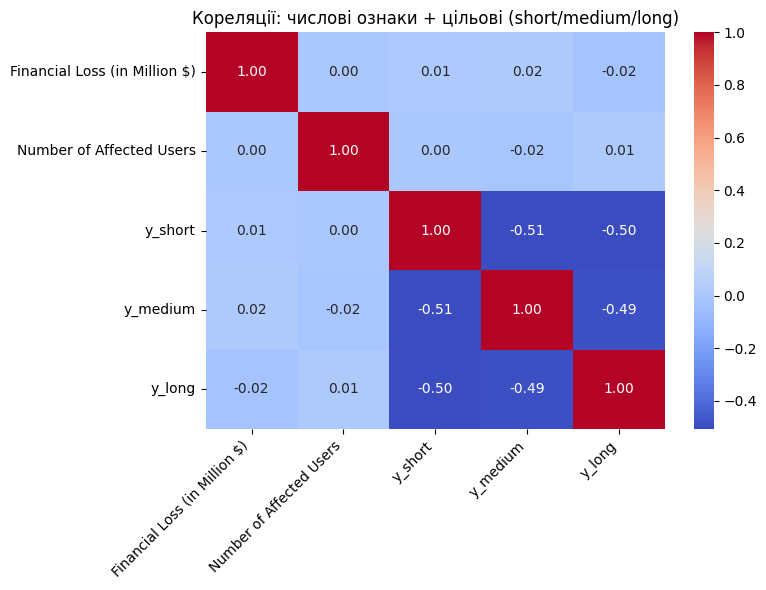

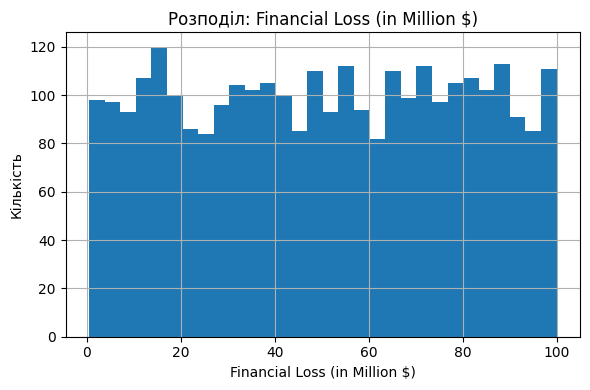

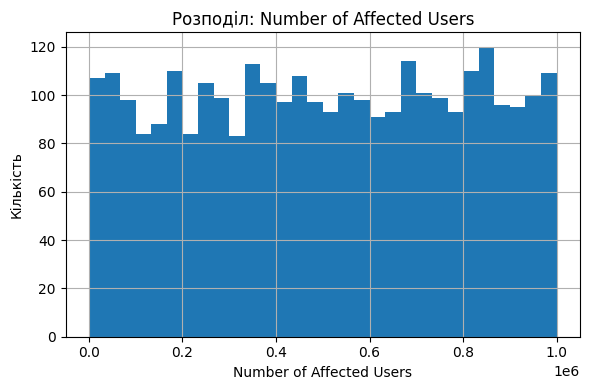

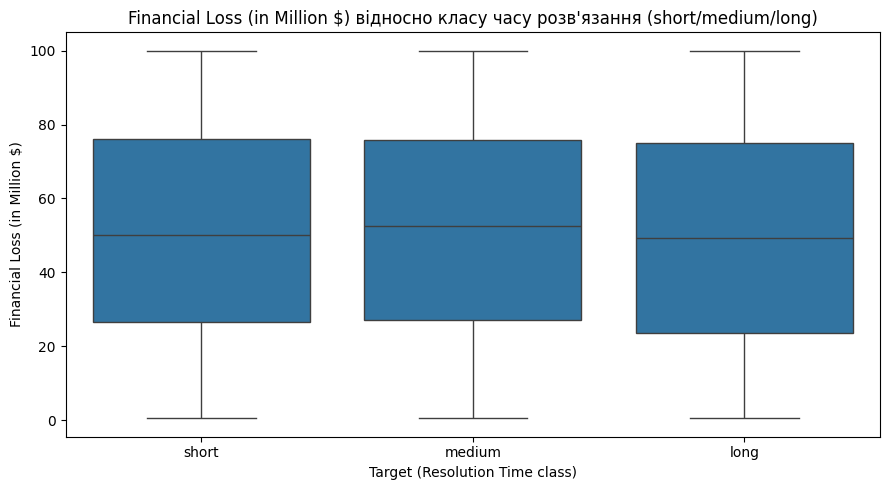

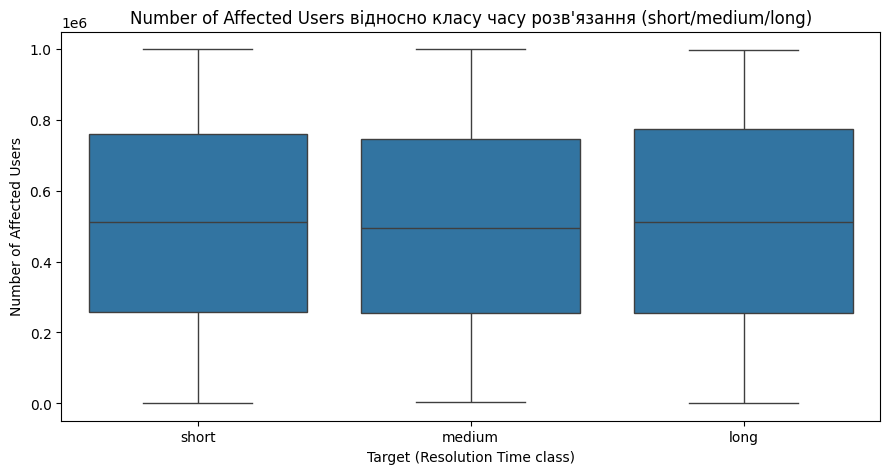

In [64]:
num_cols = [
    "Financial Loss (in Million $)",
    "Number of Affected Users",
]

# Heatmap: correlations among numeric features and with target (one-hot)
# one-hot for target (drop_first=True, two dummies; the dropped class is the baseline)
y_dum = pd.get_dummies(y, prefix="y")
# build a small frame for heatmap: numeric features + target dummies
heat_df = pd.concat([X[num_cols], y_dum.reset_index(drop=True)], axis=1)
corr = heat_df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляції: числові ознаки + цільові (short/medium/long)")
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

# Distributions of numeric features
for col in num_cols:
    plt.figure(figsize=(6,4))
    X[col].hist(bins=30)
    plt.title(f"Розподіл: {col}")
    plt.xlabel(col); plt.ylabel("Кількість")
    plt.tight_layout(); plt.show()

# Numeric features vs target classes
for col in num_cols:
    plt.figure(figsize=(9,5))
    sns.boxplot(x=y, y=X[col])
    plt.title(f"{col} відносно класу часу розв'язання (short/medium/long)")
    plt.xlabel("Target (Resolution Time class)"); plt.ylabel(col)
    plt.tight_layout(); plt.show()


Cлабка кореляцію між довжиною атак та фінансовими втратами чи користувачами якіх це торкнулось.


## Крок 4. Нормалізувати дані (Target - Resolution Time)


In [65]:


TGT = "Incident Resolution Time (in Hours)"
DROP_COLS = ["Year"]

# Equal-frequency bins (3 classes): short / medium / long
y = pd.qcut(
    df[TGT],
    q=3,
    labels=["short","medium","long"],
)

print("Overall class counts:\n", y.value_counts())

# Drop the raw target to avoid leakage
X = df.drop(columns=DROP_COLS + [TGT])

# Split so each split preserves class proportions
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline (numeric: impute+scale; categorical: impute+one-hot)
num_cols = X_train_raw.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train_raw.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)


print(f"\n================================")
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print(f"\n================================")
print("Test  class distribution:\n", y_test.value_counts(normalize=True))



Overall class counts:
 Incident Resolution Time (in Hours)
short     1026
medium     991
long       983
Name: count, dtype: int64

Train class distribution:
 Incident Resolution Time (in Hours)
short     0.342083
medium    0.330417
long      0.327500
Name: proportion, dtype: float64

Test  class distribution:
 Incident Resolution Time (in Hours)
short     0.341667
medium    0.330000
long      0.328333
Name: proportion, dtype: float64


## Крок 5. Провести навчання класифікаторів (Target - Resolution Time)


**kNN (k-Nearest Neighbors)**

Це алгоритм класифікації, який працює за принципом:
«Скажи мені, хто твої сусіди, і я скажу, хто ти».

Маємо новий об’єкт → він порівнюється з усіма іншими об’єктами у тренувальній вибірці.

Обчислюється відстань (наприклад, Євклідова або Манхеттенська) між точками.

Беремо k найближчих сусідів і дивимося, до якого класу вони належать.

Новому об’єкту присвоюємо той клас, який серед сусідів зустрічається найчастіше (або з найбільшою вагою, якщо враховуємо відстані).


================ kNN ================
Best params: {'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance'}
CV f1_macro: 0.3424
Test accuracy: 0.3300
Test f1_macro: 0.3291

classification_report:
               precision    recall  f1-score   support

        long       0.32      0.28      0.30       197
      medium       0.34      0.37      0.36       198
       short       0.33      0.34      0.33       205

    accuracy                           0.33       600
   macro avg       0.33      0.33      0.33       600
weighted avg       0.33      0.33      0.33       600



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.34158975 0.341154   0.34235383        nan 0.33338046
 0.31529257 0.32520129        nan 0.33237196 0.32563437 0.33421726
        nan 0.33288474 0.33625496 0.34075304        nan 0.33652637
 0.32758152 0.3307042         nan 0.33931086 0.33784938 0.33230394]
  warnings.warn(


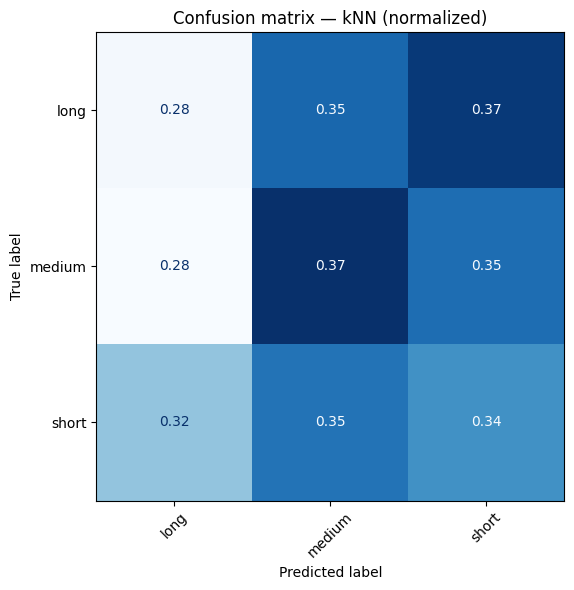

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORING = "f1_macro"

results = []

pipe_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier())])
grid_knn = {
    "clf__n_neighbors": [3,5,7,9,11,15], # скільки сусідів враховуємо
    "clf__weights": ["uniform", "distance"], # рівні ваги чи ближчі важливіші
    "clf__p": [1,2],  # 1=Manhattan, 2=Euclidean
}
results.append(fit_eval(pipe_knn, grid_knn, "kNN"))

Модель kNN з оптимальними параметрами дає результат трохи кращий за випадкове вгадування, але все одно дуже слабкий (F1 ~0.33).

Це свідчить, що ознаки (features) у датасеті погано відокремлюють класи часу розв’язання інцидентів.

Сам алгоритм kNN у даному випадку неефективний.

**Дерево ухвалення рішень**


================ Decision Tree ================
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CV f1_macro: 0.3460
Test accuracy: 0.3467
Test f1_macro: 0.3465

classification_report:
               precision    recall  f1-score   support

        long       0.32      0.38      0.35       197
      medium       0.34      0.35      0.35       198
       short       0.38      0.31      0.34       205

    accuracy                           0.35       600
   macro avg       0.35      0.35      0.35       600
weighted avg       0.35      0.35      0.35       600



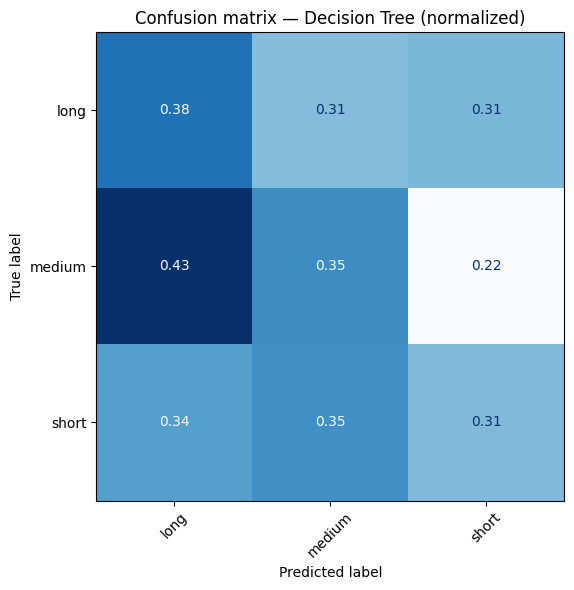

In [ ]:
pipe_dt = Pipeline([("prep", preprocessor),
                    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))])
grid_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"], # міра «чистоти вузлів
    "clf__max_depth": [None, 5, 10, 20], # максимальна глибина дерева
    "clf__min_samples_split": [2, 5, 10], # мінімальна кількість прикладів для поділу вузла
    "clf__min_samples_leaf": [1, 2, 5], # мінімальна кількість прикладів у кінцевому листку
}
results.append(fit_eval(pipe_dt, grid_dt, "Decision Tree"))

Decision Tree дає трохи вищий f1_macro (0.35), ніж kNN (0.33).

Результат усе ще далекий від прийнятного для практики причина, ймовірно, в тому, що обрані ознаки (Financial Loss, Number of Users тощо) не несуть достатньо інформації про тривалість інциденту.

**SVM**

Це алгоритм машинного навчання, який намагається знайти лінію (у 2D), площину (у 3D) чи гіперплощину (у багатовимірному просторі), яка найкраще розділяє класи.


================ SVM (RBF) ================
Best params: {'clf__C': 10, 'clf__gamma': 'scale'}
CV f1_macro: 0.3390
Test accuracy: 0.3217
Test f1_macro: 0.3212

classification_report:
               precision    recall  f1-score   support

        long       0.30      0.29      0.29       197
      medium       0.31      0.32      0.31       198
       short       0.36      0.36      0.36       205

    accuracy                           0.32       600
   macro avg       0.32      0.32      0.32       600
weighted avg       0.32      0.32      0.32       600



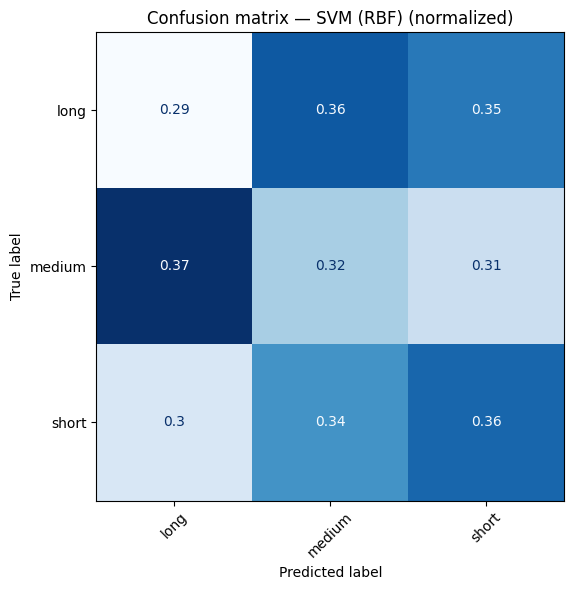

In [ ]:
pipe_svm = Pipeline([("prep", preprocessor),
                     ("clf", SVC(kernel="rbf", class_weight="balanced"))])
grid_svm = {
    "clf__C": [0.1, 1, 10, 100],  # наскільки сильно штрафуємо за помилки
    "clf__gamma": ["scale", "auto", 0.01, 0.1, 1.0], # радіус впливу точок
}
results.append(fit_eval(pipe_svm, grid_svm, "SVM (RBF)"))

SVM з RBF-ядром на цих даних показав найгірший результат серед протестованих моделей (F1 0.32).

Це означає, що наявні ознаки (наприклад, Financial Loss, Number of Users) не дають чітких меж між класами часу розв’язання інцидентів.

**Random Forest**

Random Forest — це багато дерев рішень, які працюють разом, щоб давати більш стабільні та точні результати.


================ Random Forest ================
Best params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
CV f1_macro: 0.3386
Test accuracy: 0.3217
Test f1_macro: 0.3201

classification_report:
               precision    recall  f1-score   support

        long       0.28      0.26      0.27       197
      medium       0.35      0.34      0.34       198
       short       0.33      0.37      0.35       205

    accuracy                           0.32       600
   macro avg       0.32      0.32      0.32       600
weighted avg       0.32      0.32      0.32       600



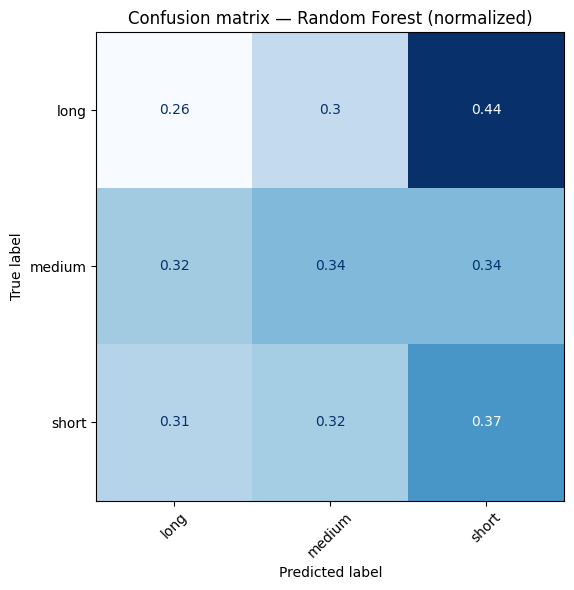

In [ ]:
pipe_rf = Pipeline([("prep", preprocessor),
                    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))])
grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}
results.append(fit_eval(pipe_rf, grid_rf, "Random Forest"))

Random Forest не покращив результати у порівнянні з одним деревом.

Ймовірно, через те що ознаки (features) самі по собі малоінформативні, і навіть багато дерев не допомагають.

У цій задачі поки Decision Tree (f1_macro 0.35) залишається кращим вибором, ніж kNN (0.33), SVM (0.32) чи Random Forest (0.32).

**AdaBoost**

AdaBoost (Adaptive Boosting) — це ансамблевий метод машинного навчання, який поєднує багато «слабких» моделей (часто дрібні дерева рішень) у одну «сильну» модель.


================ AdaBoost ================
Best params: {'clf__learning_rate': 1.0, 'clf__n_estimators': 200}
CV f1_macro: 0.3224
Test accuracy: 0.3367
Test f1_macro: 0.3318

classification_report:
               precision    recall  f1-score   support

        long       0.30      0.23      0.26       197
      medium       0.35      0.43      0.39       198
       short       0.34      0.35      0.34       205

    accuracy                           0.34       600
   macro avg       0.33      0.34      0.33       600
weighted avg       0.33      0.34      0.33       600



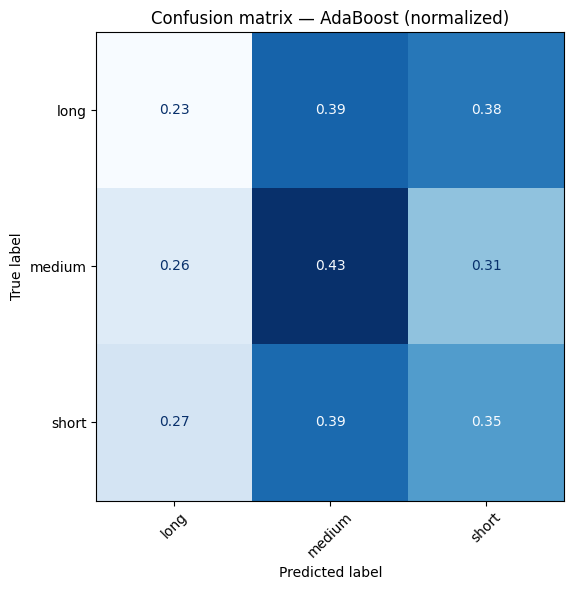

In [ ]:
pipe_ada = Pipeline([("prep", preprocessor), ("clf", AdaBoostClassifier(random_state=42))])
grid_ada = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.5, 1.0, 1.5],
}
results.append(fit_eval(pipe_ada, grid_ada, "AdaBoost"))


AdaBoost виявився слабшим за Decision Tree і приблизно на рівні kNN.

Він краще «бачить» клас medium, але зовсім погано працює з класом long.

Це ще раз показує, що ознаки не дають сильних сигналів для відокремлення класів, і навіть boosting не може витягнути високу якість.

**Обираємо найкращю модель**

In [ ]:
best_by_cv = max(results, key=lambda r: r["cv_score"])
best_by_test = max(results, key=lambda r: r["test_f1_macro"])
print("\n>>> Best by CV f1_macro:", best_by_cv["name"], f"({best_by_cv['cv_score']:.4f})")
print(">>> Best by TEST f1_macro:", best_by_test["name"], f"({best_by_test['test_f1_macro']:.4f})")


>>> Best by CV f1_macro: kNN (0.3424)
>>> Best by TEST f1_macro: AdaBoost (0.3318)


## Висновки

Оптимальні параметри підібрані для kNN, Decision Tree, SVM, Random Forest та AdaBoost за допомогою GridSearch.

Найкращий результат на крос-валідації показав kNN (F1 ≈ 0.3424).

Найкращий результат на тестовій вибірці показав AdaBoost (F1 ≈ 0.3318).

Загальна якість усіх моделей низька, що вказує на потребу у більш інформативних ознаках.

# Target - Attack Type

## Крок 3. Візуалізувати дані (Target - Attack Type)


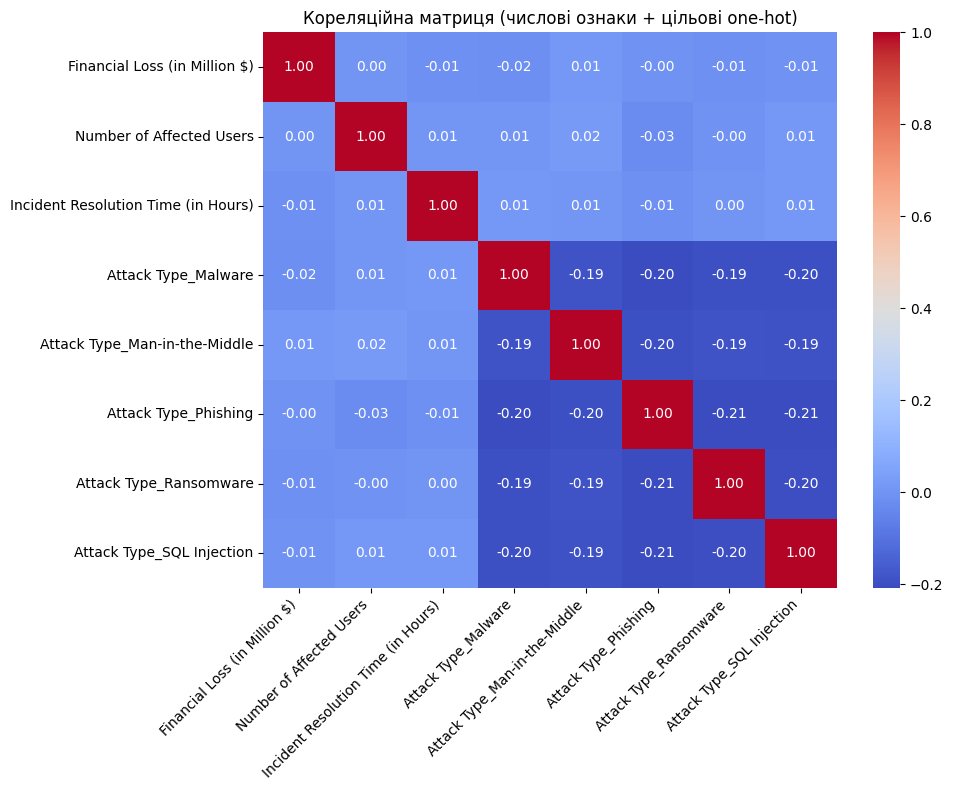

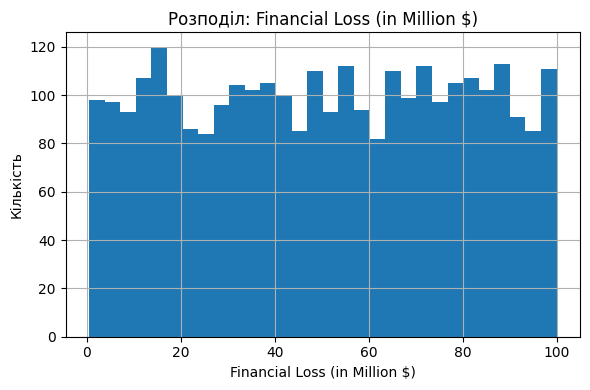

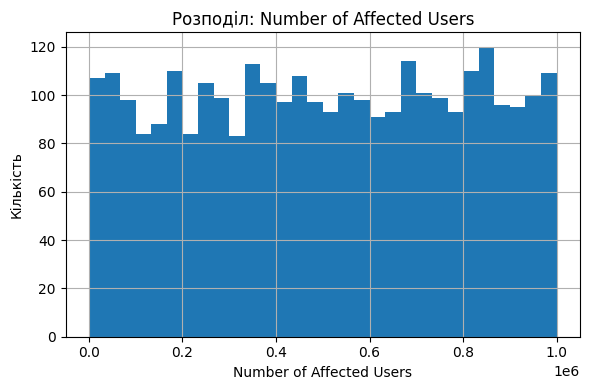

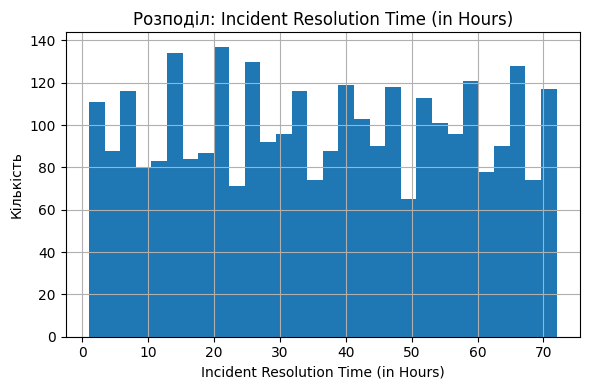

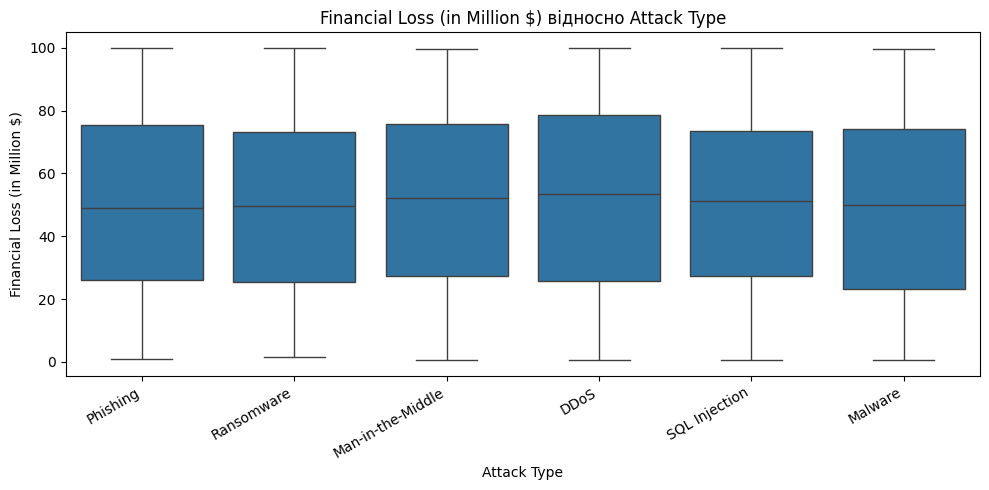

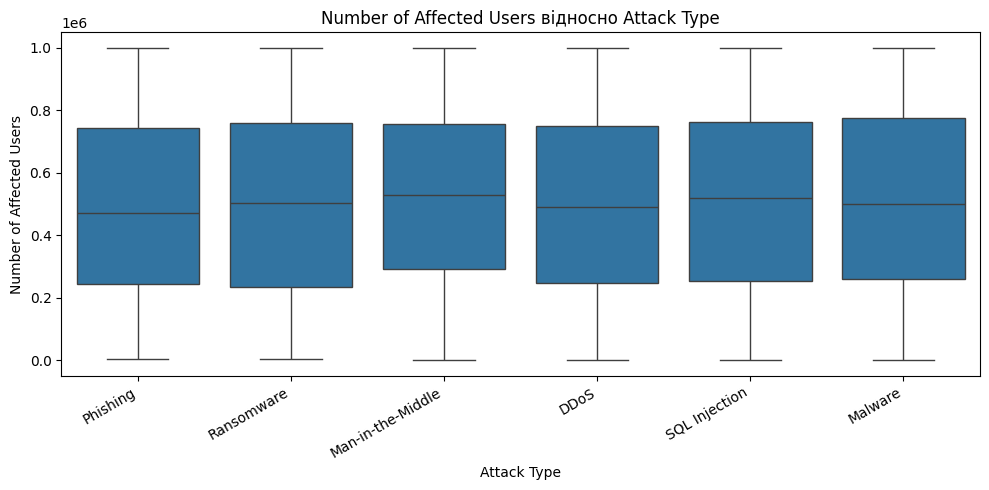

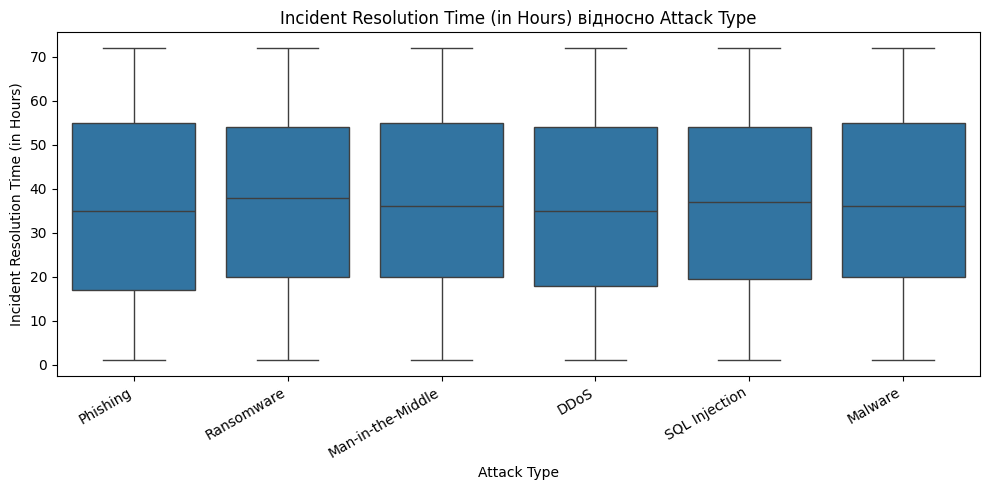

In [66]:
target_col = "Attack Type"
num_cols = [
    "Financial Loss (in Million $)",
    "Number of Affected Users",
    "Incident Resolution Time (in Hours)",
]

df_encoded = pd.get_dummies(df.drop(columns=["Year"]), drop_first=True)

attack_dummies = [c for c in df_encoded.columns if c.startswith(f"{target_col}_")]
heatmap_cols = num_cols + attack_dummies
corr = df_encoded[heatmap_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляційна матриця (числові ознаки + цільові one-hot)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

for col in num_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f"Розподіл: {col}")
    plt.xlabel(col)
    plt.ylabel("Кількість")
    plt.tight_layout()
    plt.show()

for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f"{col} відносно {target_col}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


##  Крок 4. Нормалізувати дані (Target - Attack Type)


In [78]:
target_col = "Attack Type"
X = df.drop(columns=["Year", target_col])
y = df[target_col]

# numeric / categorical splits
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # <-- fix
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2400, 33)
X_test shape: (600, 33)


## Крок 5. Провести навчання наступних класифікаторів (Target - Attack Type)


In [79]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORING = "f1_macro"   # good for multi-class & imbalance

results2 = []

**kNN (k-Nearest Neighbors)**

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.17356139 0.13893443 0.16269301        nan 0.16321765
 0.14665214 0.15798304        nan 0.15942582 0.14560858 0.15695293
        nan 0.16479862 0.16742517 0.16364939        nan 0.16533906
 0.16080092 0.16067279        nan 0.16632349 0.16251629 0.16181008]
  warnings.warn(



================ kNN ================
Best params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
CV f1_macro: 0.1736
Test accuracy: 0.1767
Test f1_macro: 0.1764

classification_report:
                    precision    recall  f1-score   support

             DDoS       0.20      0.21      0.20       106
          Malware       0.18      0.16      0.17        97
Man-in-the-Middle       0.18      0.17      0.18        92
         Phishing       0.17      0.16      0.17       106
       Ransomware       0.19      0.21      0.20        99
    SQL Injection       0.13      0.14      0.14       100

         accuracy                           0.18       600
        macro avg       0.18      0.18      0.18       600
     weighted avg       0.18      0.18      0.18       600



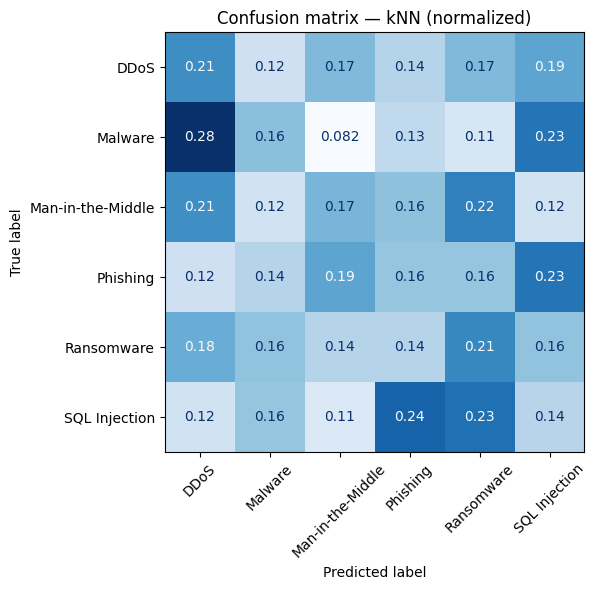

In [80]:
pipe_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier())])
grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}
results2.append(fit_eval(pipe_knn, grid_knn, "kNN"))


**Дерево ухвалення рішень**



================ Decision Tree ================
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
CV f1_macro: 0.1824
Test accuracy: 0.1617
Test f1_macro: 0.1627

classification_report:
                    precision    recall  f1-score   support

             DDoS       0.19      0.16      0.17       106
          Malware       0.15      0.16      0.15        97
Man-in-the-Middle       0.12      0.17      0.14        92
         Phishing       0.17      0.15      0.16       106
       Ransomware       0.21      0.17      0.19        99
    SQL Injection       0.17      0.15      0.16       100

         accuracy                           0.16       600
        macro avg       0.17      0.16      0.16       600
     weighted avg       0.17      0.16      0.16       600



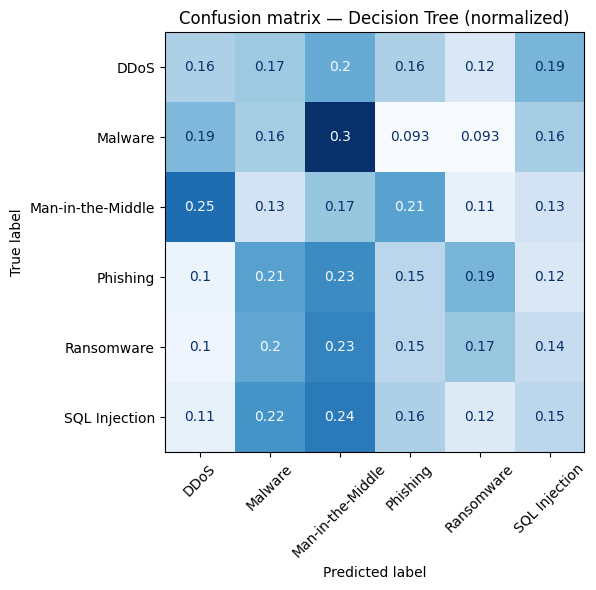

In [81]:
pipe_dt = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))])
grid_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
}
results2.append(fit_eval(pipe_dt, grid_dt, "Decision Tree"))


**SVM**


================ SVM (RBF) ================
Best params: {'clf__C': 100, 'clf__gamma': 'scale'}
CV f1_macro: 0.1730
Test accuracy: 0.1783
Test f1_macro: 0.1760

classification_report:
                    precision    recall  f1-score   support

             DDoS       0.17      0.24      0.20       106
          Malware       0.16      0.20      0.18        97
Man-in-the-Middle       0.20      0.18      0.19        92
         Phishing       0.17      0.14      0.16       106
       Ransomware       0.21      0.21      0.21        99
    SQL Injection       0.14      0.10      0.12       100

         accuracy                           0.18       600
        macro avg       0.18      0.18      0.18       600
     weighted avg       0.18      0.18      0.18       600



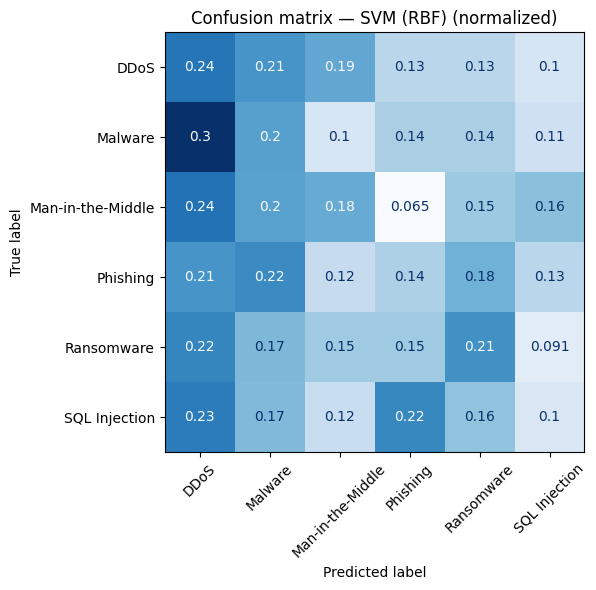

In [82]:
pipe_svm = Pipeline([("prep", preprocessor), ("clf", SVC(kernel="rbf", class_weight="balanced"))])
grid_svm = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
}
results2.append(fit_eval(pipe_svm, grid_svm, "SVM (RBF)"))



**Random Forest**


================ Random Forest ================
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
CV f1_macro: 0.1779
Test accuracy: 0.1733
Test f1_macro: 0.1717

classification_report:
                    precision    recall  f1-score   support

             DDoS       0.18      0.19      0.19       106
          Malware       0.16      0.14      0.15        97
Man-in-the-Middle       0.17      0.20      0.18        92
         Phishing       0.23      0.24      0.23       106
       Ransomware       0.16      0.16      0.16        99
    SQL Injection       0.12      0.11      0.11       100

         accuracy                           0.17       600
        macro avg       0.17      0.17      0.17       600
     weighted avg       0.17      0.17      0.17       600



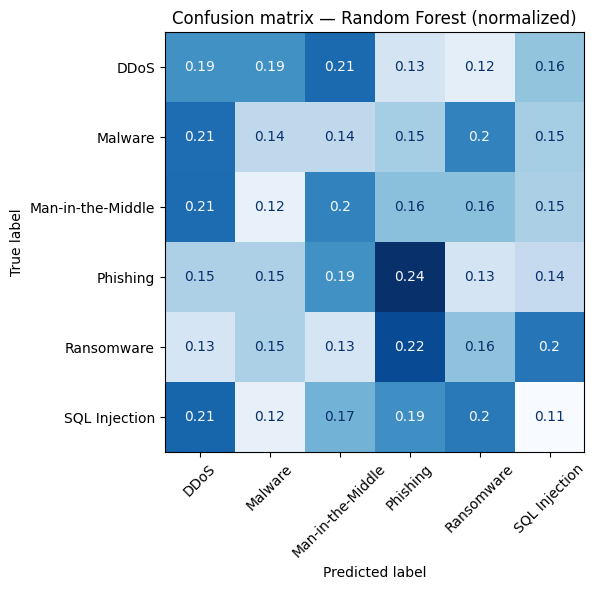

In [83]:
pipe_rf = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))])
grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}
results2.append(fit_eval(pipe_rf, grid_rf, "Random Forest"))



**AdaBoost**


================ AdaBoost ================
Best params: {'clf__learning_rate': 1.5, 'clf__n_estimators': 100}
CV f1_macro: 0.1780
Test accuracy: 0.1650
Test f1_macro: 0.1545

classification_report:
                    precision    recall  f1-score   support

             DDoS       0.15      0.18      0.16       106
          Malware       0.14      0.10      0.12        97
Man-in-the-Middle       0.06      0.04      0.05        92
         Phishing       0.22      0.31      0.26       106
       Ransomware       0.18      0.22      0.20        99
    SQL Injection       0.20      0.11      0.14       100

         accuracy                           0.17       600
        macro avg       0.16      0.16      0.15       600
     weighted avg       0.16      0.17      0.16       600



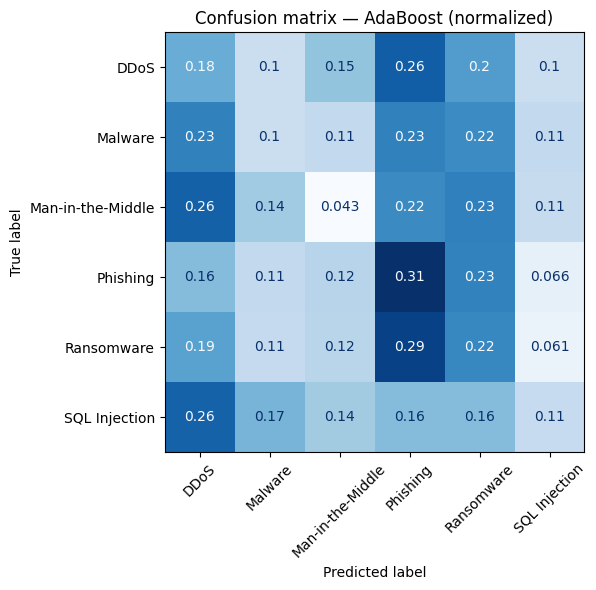

In [84]:
pipe_ada = Pipeline([("prep", preprocessor), ("clf", AdaBoostClassifier(random_state=42))])
grid_ada = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.5, 1.0, 1.5],
}
results2.append(fit_eval(pipe_ada, grid_ada, "AdaBoost"))

**Pick overall best by CV f1_macro (or change to test_f1_macro)**

In [85]:
best_by_cv = max(results2, key=lambda r: r["cv_score"])
best_by_test = max(results2, key=lambda r: r["test_f1_macro"])

print("\n>>> Best by CV f1_macro:", best_by_cv["name"], f"({best_by_cv['cv_score']:.4f})")
print(">>> Best by TEST f1_macro:", best_by_test["name"], f"({best_by_test['test_f1_macro']:.4f})")



>>> Best by CV f1_macro: Decision Tree (0.1824)
>>> Best by TEST f1_macro: kNN (0.1764)


## Висновки

У цьому прогоні моделі фактично «провалилися». Якщо F1 нижче, ніж випадковий baseline